#### reading material

In [5]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from tqdm.auto import tqdm 

import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error #=mean error (Simon 2012)
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from scipy.optimize import minimize

from scipy.spatial import distance
from sklearn.metrics.pairwise import nan_euclidean_distances

from matplotlib.lines import Line2D
from matplotlib import rcParams, cycler
from sklearn.preprocessing import PowerTransformer

import sys
from impyute.imputation.cs import fast_knn
from impyute.imputation.cs import mice

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [ ]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [ ]:
# https://support.sas.com/resources/papers/proceedings/proceedings/sugi30/203-30.pdf
# https://books.google.co.il/books?id=KFAnkvqD8CgC&pg=PA61&redir_esc=y#v=onepage&q&f=false
# https://www.theanalysisfactor.com/the-fundamental-difference-between-principal-component-analysis-and-factor-analysis/
# https://www.mathworks.com/help/stats/examples/factor-analysis.html
# https://iescoders.com/exploratory-factor-analysis/

In [7]:
# load data
df = pd.read_csv("~/Documents/saved_data_from_notebooks/RF_add1.csv") 

In [33]:
df

,AFULA,ANTOKOLSKY,HOLON,IRONID,KVISH4,REMEZ,YAD_LEBANIM,YEFET_YAFO,AHUZA_G,ATZMAUT_B,...,ORT,ROVA_TV,SDEROT,SDE_YOAV,YAHALOM,BEER_SHEVA,EAST_NEGEV,KFAR_MASARIK,PARDES_HANA,RAANANA
0,27.45,28.10,55.0,43.80,34.80,35.67,23.76,32.27,17.8,31.2,...,39.20,39.20,45.7,35.10,52.40,35.3,13.83,9.30,16.9,29.40
1,24.02,26.67,55.0,43.76,35.00,43.40,18.50,26.19,17.8,38.8,...,49.00,49.00,54.0,34.40,42.40,33.1,19.95,15.60,16.9,26.73
2,29.18,27.70,55.0,46.38,43.72,45.86,21.70,34.96,16.2,43.3,...,43.80,43.80,48.0,44.90,42.67,25.9,28.39,20.20,11.9,38.69
3,19.40,26.30,64.6,48.70,44.01,40.65,23.60,37.76,17.1,39.3,...,39.40,39.40,25.6,34.60,45.40,26.4,21.93,16.60,15.1,35.50
4,25.70,28.00,71.0,44.70,32.94,28.13,25.00,27.66,18.3,37.1,...,42.50,42.50,20.3,26.00,35.10,34.6,21.65,14.40,17.0,33.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105161,19.40,27.30,27.0,29.80,29.61,26.00,14.90,28.40,24.7,19.4,...,18.62,18.06,23.6,5.10,20.46,18.3,8.30,25.90,32.5,15.80
105162,21.68,26.90,28.9,23.10,25.87,31.80,14.80,38.40,23.5,29.4,...,17.54,18.09,15.6,9.25,18.05,17.3,24.20,21.60,38.0,33.40
105163,26.30,28.50,21.8,28.80,26.80,30.50,16.90,40.80,20.0,29.0,...,19.20,18.71,19.6,7.00,19.66,19.3,14.90,19.40,37.6,18.60
105164,22.70,29.30,24.1,23.10,33.90,31.10,18.90,43.60,18.7,28.9,...,18.92,19.02,42.8,14.30,22.87,23.7,13.30,26.80,33.0,25.88


In [ ]:
# Bartlett’s Test

In [11]:
chi_square_value,p_value=calculate_bartlett_sphericity(df)
chi_square_value, p_value

(5301086.238691375, 0.0)

In [ ]:
# Kaiser-Meyer-Olkin (KMO) Test

In [12]:

kmo_all,kmo_model=calculate_kmo(df)
kmo_model

0.9864025974424117

In [26]:
fa = FactorAnalyzer()

In [27]:
fa.fit(df)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

FactorAnalyzer(rotation_kwargs={})

array([24.24330935,  2.07115241,  1.34684644,  0.81734066,  0.38906624,
        0.37382714,  0.33766111,  0.31911363,  0.29851798,  0.2799224 ,
        0.26775461,  0.23576525,  0.21630204,  0.21311889,  0.2015623 ,
        0.18628146,  0.18017646,  0.17718492,  0.16582257,  0.16201526,
        0.14839486,  0.14675941,  0.13405586,  0.12854055,  0.12645096,
        0.12284043,  0.11542961,  0.11028495,  0.09810684,  0.09584521,
        0.08515682,  0.07754957,  0.06556619,  0.0622776 ])

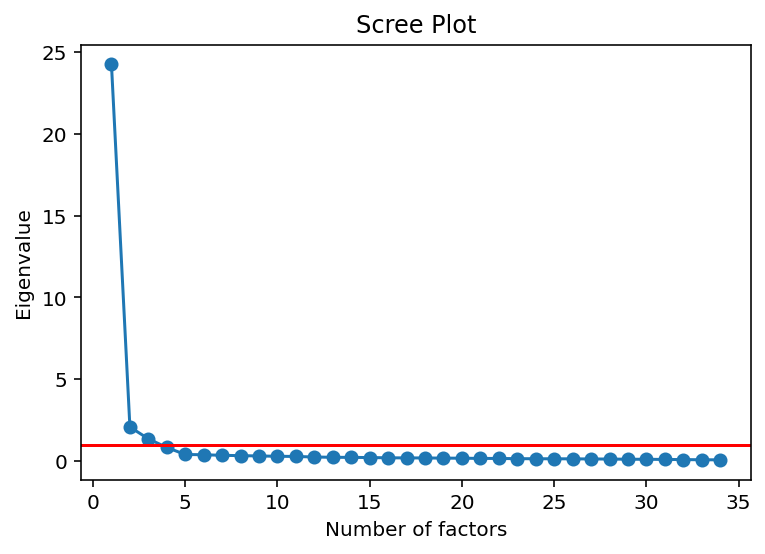

In [28]:
# Create scree plot using matplotlib
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Number of factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1,c='r')
plt.show();

In [63]:
NUM = 4

In [64]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=NUM, rotation='promax')
fa.fit(df)

FactorAnalyzer(n_factors=4, rotation_kwargs={})

In [65]:
fa.loadings_

array([[ 0.01018329,  0.54428361,  0.08250562,  0.36457336],
       [ 0.19765639,  0.05486402,  0.70269869,  0.05860016],
       [ 0.2831687 ,  0.05268768,  0.61160335,  0.0168297 ],
       [ 0.16007334,  0.10237424,  0.68955143,  0.00345629],
       [ 0.20613101,  0.07932878,  0.66917596,  0.04222398],
       [ 0.09675634, -0.06758858,  0.82130535,  0.07119234],
       [ 0.50759113,  0.14319857,  0.365059  , -0.00122888],
       [ 0.24449122,  0.13212011,  0.52506429, -0.02780583],
       [ 0.12204399,  0.72253832, -0.03028552,  0.12597638],
       [ 0.00692591,  0.79200364,  0.09050446,  0.00493238],
       [ 0.12301999,  0.96919209, -0.06192037, -0.13166961],
       [-0.06753635,  0.82958707,  0.05283566,  0.11168713],
       [ 0.02421465,  0.86119341, -0.00547132, -0.04818608],
       [ 0.0287322 ,  0.89597333, -0.06471953,  0.02622911],
       [-0.0098051 ,  0.95030405, -0.00850206, -0.00912302],
       [-0.01308432,  0.94341289,  0.03273486, -0.04381363],
       [-0.181239  ,  0.

In [66]:
fa.get_factor_variance()

(array([8.38824086, 7.39780503, 3.78220674, 2.3148751 ]),
 array([0.24671297, 0.2175825 , 0.11124137, 0.06808456]),
 array([0.24671297, 0.46429547, 0.57553684, 0.6436214 ]))

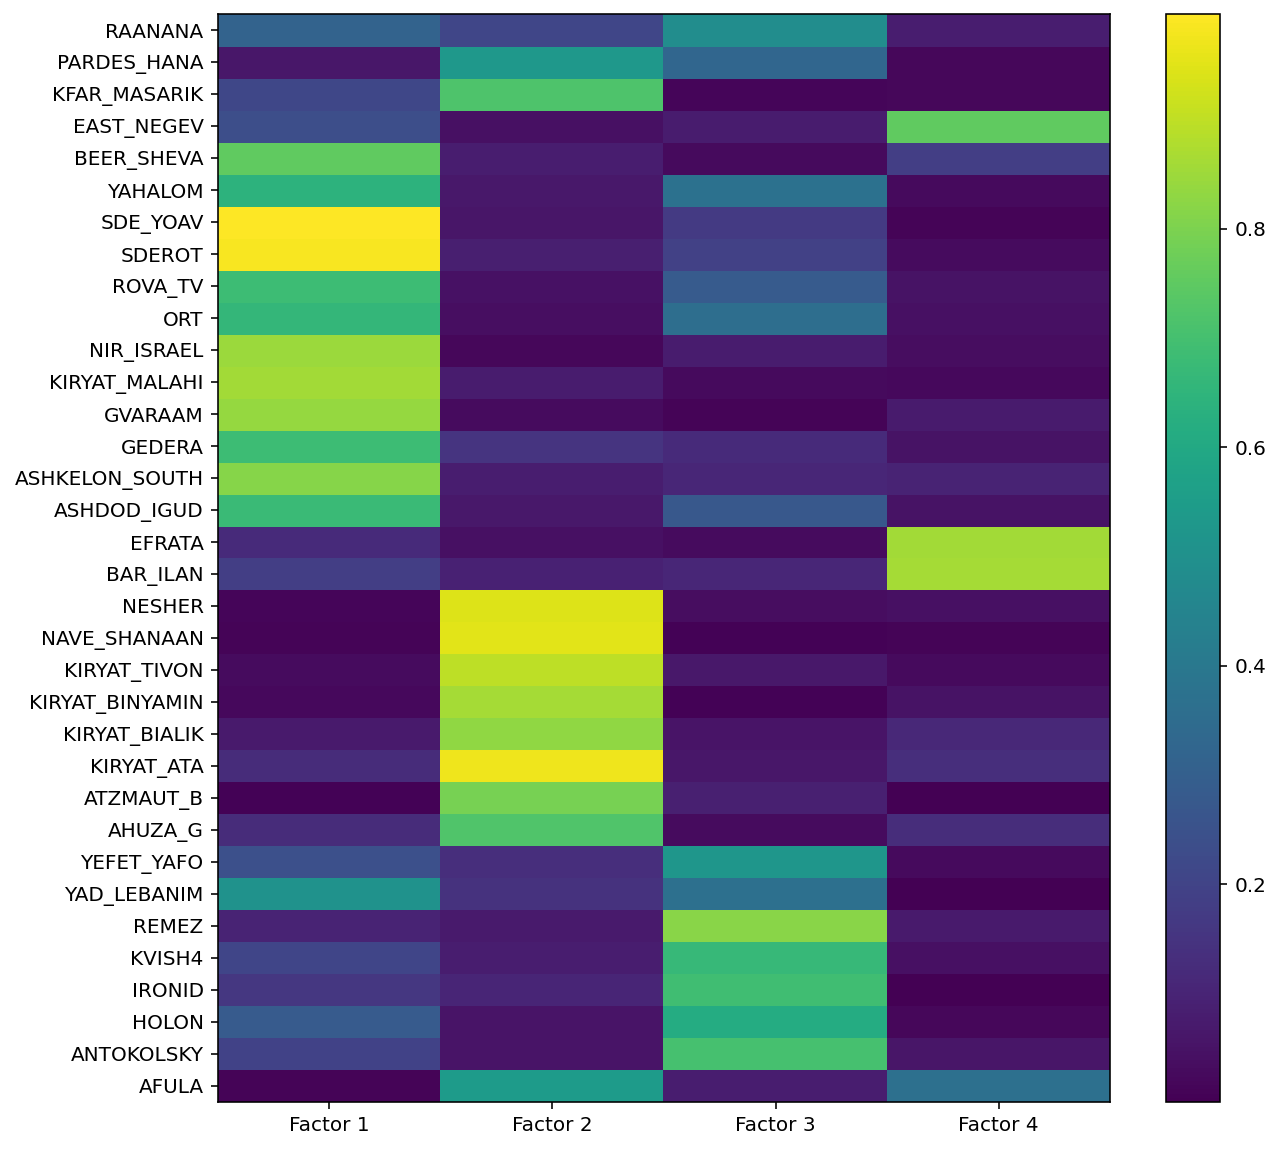

In [67]:
Z=np.abs(fa.loadings_)
fig, ax = plt.subplots(figsize=(10,10))
c = ax.pcolor(Z)
fig.colorbar(c, ax=ax)
ax.set_yticks(np.arange(fa.loadings_.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(fa.loadings_.shape[1])+0.5, minor=False)
ax.set_yticklabels(df.columns)
ax.set_xticklabels(['Factor '+str(i+1) for i in range(fa.loadings_.shape[1])])
plt.show();